In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import sklearn
from scipy.stats import randint
import os

pd.set_option('display.max_columns', None)
os.getcwd()

'c:\\Users\\parke\\data_work\\datascience\\machine_learning\\house_prices'

# House Prices-  Advanced Regression Techniques
This regression task comes from a Kaggle competition of the same name. The target variable is the Sale Price. Evaluation is based on the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sale price.  The dataset contains selling prices and home details for houses sold in Ames Iowa. 


__[Kaggle Competition Link](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation)__ 

### Import Sklearn helper functions

In [212]:
# model selection, cross validation and hyperparam tuning
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV

# preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

# imputation
from sklearn.impute import SimpleImputer, KNNImputer

# pipelines
from sklearn.pipeline import make_pipeline

# custom transformers 
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

# dummy model for baseline comparison
from sklearn.dummy import DummyRegressor 

# classificaion model metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

## Dataset import and basic look

In [162]:
og_train = pd.read_csv('train.csv')
og_test = pd.read_csv('test.csv')

print('train size:', og_train.shape)
print('test size:', og_test.shape)

og_train.info()

train size: (1460, 81)
test size: (1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  Overall

### Optimizing the df, reduce memory, increase usability

In [151]:
# how many categories are in each of the object columns? would 'category' dtype be more appropriate?
cat_counts = pd.DataFrame(og_train.select_dtypes(include = 'object').apply(pd.Series.nunique))
cat_counts.T

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6


In [163]:
object_cols = list(og_train.select_dtypes('object').columns)

# Fill na in object cols with 'not_applicable before converting to category
og_train[object_cols] = og_train[object_cols].fillna(value = 'not_applicable')
og_train[object_cols] = og_train[object_cols].astype('category')
og_train.columns = og_train.columns.str.lower()

og_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             1460 non-null   int64   
 1   mssubclass     1460 non-null   int64   
 2   mszoning       1460 non-null   category
 3   lotfrontage    1201 non-null   float64 
 4   lotarea        1460 non-null   int64   
 5   street         1460 non-null   category
 6   alley          1460 non-null   category
 7   lotshape       1460 non-null   category
 8   landcontour    1460 non-null   category
 9   utilities      1460 non-null   category
 10  lotconfig      1460 non-null   category
 11  landslope      1460 non-null   category
 12  neighborhood   1460 non-null   category
 13  condition1     1460 non-null   category
 14  condition2     1460 non-null   category
 15  bldgtype       1460 non-null   category
 16  housestyle     1460 non-null   category
 17  overallqual    1460 non-null   in

In [177]:
og_train_describe = pd.DataFrame(og_train.describe(include = 'all'))
og_train_describe

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460,1452.000000,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,1460,1460,1379.000000,1460,1460.000000,1460.000000,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,3,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,5,NaN,4,5,6,5,5,5,7,NaN,7,NaN,NaN,NaN,6,5,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,6,7,NaN,4,NaN,NaN,6,6,3,NaN,NaN,NaN,NaN,NaN,NaN,4,5,5,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,not_applicable,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,not_applicable,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,not_applicable,not_applicable,not_applicable,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,1369,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,690,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,1453,1179,1406,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.0000

### Inspection of missing values
Note: In this dataset NA does not always indicate a null value, it may also indicate 'Not Applicable' as seen below from the data_description file

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

In [157]:
# exploring the pool quality feature: overwhelmingly houses in ames iowa just dont have a pool
og_train['poolqc'].value_counts(dropna=False)

not_applicable    1453
Gd                   3
Ex                   2
Fa                   2
Name: poolqc, dtype: int64

In [164]:
# These are the columns with null values
og_train[og_train.columns[og_train.isna().any()]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lotfrontage  1201 non-null   float64
 1   masvnrarea   1452 non-null   float64
 2   garageyrblt  1379 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


In [165]:
# These are the categorical columns with null values
(og_train[og_train.columns[og_train.isna().any()]].select_dtypes('category')).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Empty DataFrame

 Null values in the categorical variables do not represent missing data, they represent the non applicability of that question ('what is the quality of the basement?') to that house mainly because it does not have a basement. As a result I will recode these null values as something other than null

In [166]:
# These are the numerical columns with null values
(og_train[og_train.columns[og_train.isna().any()]].select_dtypes(exclude = 'category')).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lotfrontage  1201 non-null   float64
 1   masvnrarea   1452 non-null   float64
 2   garageyrblt  1379 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


In [167]:
# This is the degree of supposed NAs in columns with Na entries
og_train[og_train.columns[og_train.isna().any()]].isna().mean()

lotfrontage    0.177397
masvnrarea     0.005479
garageyrblt    0.055479
dtype: float64

### Simple EDA on training set

In [168]:
px.histogram(og_train, 
    x = 'saleprice',
    height = 400,
    width = 600,
    title = "Histogram of the target variable: saleprice").show()

In [169]:
px.histogram(og_train, 
    x = 'saleprice',
    log_x = True,
    height = 400,
    width = 600,
    title = "Histogram of the logarithm of the target variable: log(saleprice)").show()

What numerical features are most highly correlated with the target?

In [171]:
corr_to_target = pd.DataFrame(og_train.corrwith(og_train["saleprice"]).sort_values(ascending = False).reset_index())
corr_to_target.columns = ['feature','corr']
corr_to_target['abs_corr'] = np.abs(corr_to_target['corr'])
corr_to_target.sort_values(by = 'abs_corr', ascending = False).head(15)

,feature,corr,abs_corr
0,saleprice,1.000000,1.000000
1,overallqual,0.790982,0.790982
2,grlivarea,0.708624,0.708624
3,garagecars,0.640409,0.640409
4,garagearea,0.623431,0.623431
5,totalbsmtsf,0.613581,0.613581
6,1stflrsf,0.605852,0.605852
7,fullbath,0.560664,0.560664
8,totrmsabvgrd,0.533723,0.533723
9,yearbuilt,0.522897,0.522897


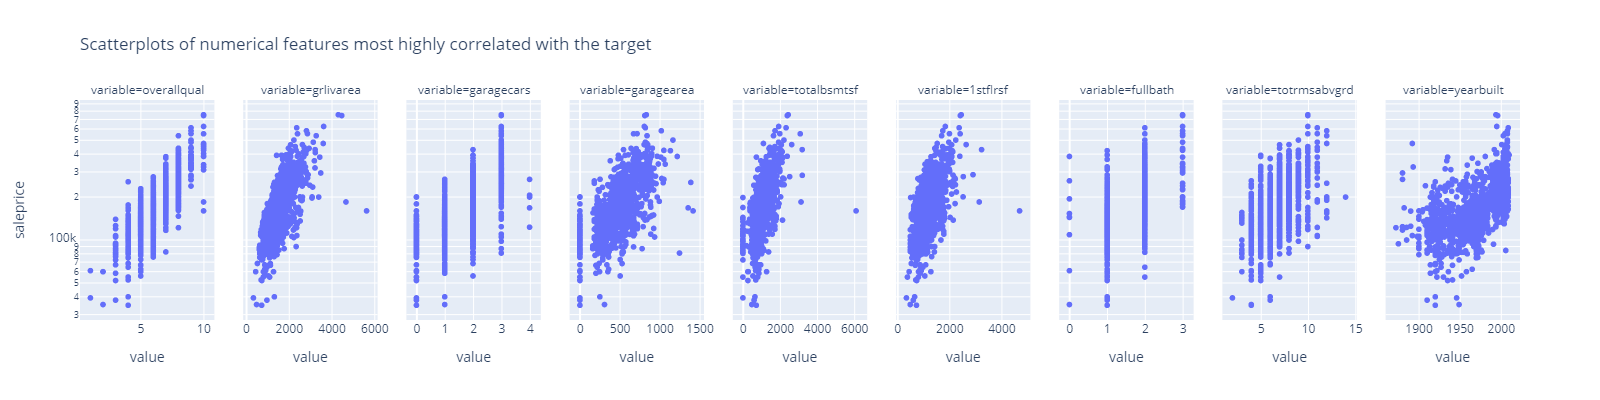

In [170]:
top_feat = og_train[['saleprice','overallqual','grlivarea','garagecars','garagearea','totalbsmtsf','1stflrsf','fullbath','totrmsabvgrd','yearbuilt']]
top_feat = top_feat.melt(id_vars='saleprice')

(px.scatter(top_feat, 
    x = 'value',
    y = 'saleprice',
    log_y= True,
    facet_col= 'variable',
    title = "Scatterplots of numerical features most highly correlated with the target",
    height = 400,
    width = 1600)
.update_xaxes(matches = None)
.show('png'))

## Split the data
Kaggle has already split the data into train and test but I still wwant a small holdout for final evaluation on my end (will use after crossvalidation)


In [103]:
def splitter(df, target, train_size, random_state):
    # Returns versions of test and train with and without the target for simple processing throughout the notebook
    train, test = train_test_split(df, train_size= train_size, random_state = random_state)

    X_train = train.drop(target, axis = 1).copy()
    y_train = train[target].copy()

    X_test = test.drop(target, axis = 1).copy()
    y_test = test[target].copy()

    return(train, test, X_train, X_test, y_train, y_test)

train, test, X_train, X_test, y_train, y_test = splitter(og_train, 'saleprice', train_size = .95, random_state = 324)


In [190]:
y_train.describe()

count      1387.000000
mean     181384.666907
std       79791.418065
min       34900.000000
25%      129900.000000
50%      163500.000000
75%      214700.000000
max      755000.000000
Name: saleprice, dtype: float64

## Estimation

In [235]:
def reg_performance_readout(model, X_train, y_train, pred, cv_scores):
    print("R2 on taining set: ", r2_score(y_train, pred))
    print("MAPE on training set ", mean_absolute_percentage_error(y_train, pred))
    print("RMSE on training set ",mean_squared_error(y_train, pred,squared = False))
    print("Official Criterion: RMSLE on training set ", mean_squared_log_error(y_train, pred, squared = False))
    print("5 Fold Cross Val RMSLE Scores: ", cv_scores)

### Baseline Model 

In [237]:
cat_processor = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_processor = make_pipeline(
    SimpleImputer(strategy = 'median')
)

preprocessing = make_column_transformer(
    (cat_processor, make_column_selector(dtype_exclude = np.number)),
    (num_processor, make_column_selector(dtype_include= np.number))

)

baseline = make_pipeline(preprocessing, DummyRegressor())
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_train)
base_cv_rmsle = np.sqrt(-cross_val_score(baseline, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(baseline, X_train, y_train, base_pred, base_cv_rmsle)

R2 on taining set:  0.0
MAPE on training set  0.36784519166735313
RMSE on training set  79762.64884852995
Official Criterion: RMSLE on training set  0.41100494716706554
5 Fold Cross Val RMSLE Scores:  [0.42504852 0.41650768 0.41357915 0.4222436  0.37679425]


In [113]:
# can use the below command to find list of metrics to specify via string in corss_val_score() under the scoring parameter
#sklearn.metrics.SCORERS.keys()

### Linear Regression 

In [238]:
cat_processor = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_processor = make_pipeline(
    SimpleImputer(strategy = 'median'),
    StandardScaler()
)

preprocessing = make_column_transformer(
    (cat_processor, make_column_selector(dtype_exclude = np.number)),
    (num_processor, make_column_selector(dtype_include= np.number))
)


from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_train)
lin_cv_rmsle = np.sqrt(-cross_val_score(lin_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(lin_reg, X_train, y_train, lin_pred, lin_cv_rmsle)


R2 on taining set:  0.9362423697935903
MAPE on training set  0.07702733028907788
RMSE on training set  20140.28683093379
Official Criterion: RMSLE on training set  0.10780671131561471
5 Fold Cross Val RMSLE Scores:  [0.20783937 0.14530659 0.2577897  0.13924716        nan]


c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
ValueError: Mean Squared Logarithmic Error cannot be used wh

### Ridge Regression

In [239]:
from sklearn.linear_model import Ridge

ridge_reg = make_pipeline(preprocessing,Ridge())
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_train)
ridge_cv_rmsle = np.sqrt(-cross_val_score(ridge_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(ridge_reg, X_train, y_train, ridge_pred, ridge_cv_rmsle)


R2 on taining set:  0.9236421301044868
MAPE on training set  0.08303999673380151
RMSE on training set  22040.755169920576
Official Criterion: RMSLE on training set  0.11473107874092917
5 Fold Cross Val RMSLE Scores:  [0.15863895 0.22954977 0.20303058 0.14233053 0.20364359]


### Lasso Regression

In [240]:
from sklearn.linear_model import Lasso

lasso_reg = make_pipeline(preprocessing, Lasso())
lasso_reg.fit(X_train, y_train)
lasso_pred = lasso_reg.predict(X_train)
lasso_cv_rmsle = np.sqrt(-cross_val_score(lasso_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(lasso_reg, X_train, y_train, lasso_pred, lasso_cv_rmsle)

c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1335023226.5454712, tolerance: 882420516.9900112

c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10498678048.888916, tolerance: 720101598.7739344

c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1572940506.8400269, tolerance: 690240670.7794358

c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of ite

R2 on taining set:  0.9362179330603578
MAPE on training set  0.07709200347132893
RMSE on training set  20144.14609974191
Official Criterion: RMSLE on training set  0.10761930951448975
5 Fold Cross Val RMSLE Scores:  [0.16593878 0.14489786 0.2522386  0.13892324        nan]


c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\parke\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
ValueError: Mean Squared Logarithmic Error cannot be used wh

### Elastic Net

In [241]:
from sklearn.linear_model import ElasticNet

elasticnet_reg = make_pipeline(preprocessing, ElasticNet())
elasticnet_reg.fit(X_train, y_train)
elasticnet_pred = elasticnet_reg.predict(X_train)
elasticnet_cv_rmsle = np.sqrt(-cross_val_score(elasticnet_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(elasticnet_reg, X_train, y_train, elasticnet_pred, elasticnet_cv_rmsle)

R2 on taining set:  0.8326711106029074
MAPE on training set  0.10327424625960252
RMSE on training set  32627.592708901888
Official Criterion: RMSLE on training set  0.1427214304603604
5 Fold Cross Val RMSLE Scores:  [0.14453572 0.25154008 0.17207727 0.152663   0.12703003]


### Random Forest

In [242]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = make_pipeline(preprocessing, RandomForestRegressor())
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_train)
rf_cv_rmsle = np.sqrt(-cross_val_score(rf_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(rf_reg, X_train, y_train, rf_pred, rf_cv_rmsle)

R2 on taining set:  0.9799066149240228
MAPE on training set  0.038185477230384846
RMSE on training set  11306.446230579428
Official Criterion: RMSLE on training set  0.05894947282288931
5 Fold Cross Val RMSLE Scores:  [0.14596421 0.15349831 0.15663661 0.14644218 0.11886838]


### Gradient Boosted Regression Trees

In [243]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = make_pipeline(preprocessing, GradientBoostingRegressor())
gb_reg.fit(X_train, y_train)
gb_pred = gb_reg.predict(X_train)
gb_cv_rmsle = np.sqrt(-cross_val_score(gb_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(gb_reg, X_train, y_train, gb_pred, gb_cv_rmsle)

R2 on taining set:  0.9689229020552881
MAPE on training set  0.06411877474797768
RMSE on training set  14061.116171737962
Official Criterion: RMSLE on training set  0.08625206672170865
5 Fold Cross Val RMSLE Scores:  [0.12899873 0.13886297 0.14721214 0.13506699 0.11105625]


### Histogram Based Gradient Boosted Regression Trees

In [244]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb_preprocessing = make_column_transformer(
    (
        OneHotEncoder(sparse = False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

hgb_reg = make_pipeline(
    hgb_preprocessing, HistGradientBoostingRegressor(random_state=42)
)

hgb_reg.fit(X_train, y_train)
hgb_pred = hgb_reg.predict(X_train)
hgb_cv_rmsle = np.sqrt(-cross_val_score(hgb_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error'))

reg_performance_readout(hgb_reg, X_train, y_train, hgb_pred, hgb_cv_rmsle)

R2 on taining set:  0.9794784862620368
MAPE on training set  0.03318751838293031
RMSE on training set  11426.264272614284
Official Criterion: RMSLE on training set  0.054390882964741136
5 Fold Cross Val RMSLE Scores:  [0.13734615 0.14539419 0.14634424 0.12999027 0.12065818]


## Comparing Model Output
Notes: ensemble methods appear to outperform traditional regression models, additionaly GBRT appears much fasterr copmutationaly than RF of HGBRT

In [261]:
cv_scores = pd.DataFrame({'linear':lin_cv_rmsle,
                    'ridge':ridge_cv_rmsle,
                    'lasso':lasso_cv_rmsle,
                    'elastic':elasticnet_cv_rmsle,
                    'rforest':rf_cv_rmsle,
                    'gradboost':gb_cv_rmsle,
                    'histgboost':hgb_cv_rmsle})

cv_scores.describe()

,linear,ridge,lasso,elastic,rforest,gradboost,histgboost
count,4.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000
mean,0.187546,0.187439,0.175500,0.169569,0.144282,0.132239,0.135947
std,0.056163,0.035858,0.052455,0.048599,0.014924,0.013558,0.010823
min,0.139247,0.142331,0.138923,0.127030,0.118868,0.111056,0.120658
25%,0.143792,0.158639,0.143404,0.144536,0.145964,0.128999,0.129990
50%,0.176573,0.203031,0.155418,0.152663,0.146442,0.135067,0.137346
75%,0.220327,0.203644,0.187514,0.172077,0.153498,0.138863,0.145394
max,0.257790,0.229550,0.252239,0.251540,0.156637,0.147212,0.146344


In [267]:
px.box(cv_scores.melt(var_name = 'model', value_name='RMSLE'),
    x = 'model',
    y = 'RMSLE',
    height = 600,
    width = 800,
    title = "Boxplots of model RMSLE scores across 5-Fold CV").show()

In [275]:
model_predictions = pd.DataFrame({'linear':lin_pred,
                    'ridge':ridge_pred,
                    'lasso':lasso_pred,
                    'elastic':elasticnet_pred,
                    'rforest':rf_pred,
                    'gradboost':gb_pred,
                    'histgboost':hgb_pred})

model_predictions.head()

,linear,ridge,lasso,elastic,rforest,gradboost,histgboost
0,205548.995814,200090.959697,205377.528368,225155.426025,191507.68,211174.375577,182815.416967
1,103382.329409,104678.329164,104021.457901,101511.179415,113336.50,100596.302533,113386.322128
2,90884.054766,91942.052815,91073.158815,99184.579378,105007.19,90094.646630,92153.982379
3,204966.131152,203845.671234,205022.252770,215835.707645,215005.87,199298.743447,210629.275388
4,229707.914548,227325.447976,229631.030625,200143.051926,216329.00,220698.197786,215662.472204


In [273]:
train.shape

(1387, 81)

In [279]:
train_plus = train.copy().reset_index(drop = True)
train_plus.head()


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1416,120,RL,51.0,3635,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2007,2007,Hip,CompShg,VinylSd,VinylSd,BrkFace,130.0,Gd,TA,PConc,Gd,TA,No,ALQ,988,Unf,0,398,1386,GasA,Ex,Y,SBrkr,1569,0,0,1569,0,1,2,0,1,1,Gd,7,Typ,1,TA,Attchd,2007.0,RFn,3,660,TA,TA,Y,143,20,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,175900
1,75,50,RM,60.0,5790,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,3,6,1915,1950,Gambrel,CompShg,VinylSd,VinylSd,None,0.0,Gd,Gd,CBlock,Fa,TA,No,Unf,0,Unf,0,840,840,GasA,Gd,N,SBrkr,840,765,0,1605,0,0,2,0,3,2,TA,8,Typ,0,NaN,Detchd,1915.0,Unf,1,379,TA,TA,Y,0,0,202,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,107400
2,750,50,RL,50.0,8405,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,4,3,1945,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,Wall,TA,N,FuseF,1088,441,0,1529,0,0,2,0,4,1,TA,9,Mod,0,NaN,Detchd,1945.0,Unf,1,240,TA,TA,N,92,0,185,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal,98000
3,383,60,RL,79.0,9245,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,939,939,GasA,Ex,Y,SBrkr,939,858,0,1797,0,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2006.0,RFn,2,639,TA,TA,Y,144,53,0,0,0,0,NaN,NaN,NaN,0,4,2007,WD,Normal,213500
4,471,120,RL,NaN,6820,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1985,1985,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,368,BLQ,1120,0,1488,GasA,TA,Y,SBrkr,1502,0,0,1502,1,0,1,1,1,1,Gd,4,Typ,0,NaN,Attchd,1985.0,RFn,2,528,TA,TA,Y,0,54,0,0,140,0,NaN,NaN,NaN,0,6,2010,WD,Normal,212000


In [280]:
train_plus = pd.concat([train_plus,model_predictions], axis=1)
train_plus.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,linear,ridge,lasso,elastic,rforest,gradboost,histgboost
0,1416,120,RL,51.0,3635,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2007,2007,Hip,CompShg,VinylSd,VinylSd,BrkFace,130.0,Gd,TA,PConc,Gd,TA,No,ALQ,988,Unf,0,398,1386,GasA,Ex,Y,SBrkr,1569,0,0,1569,0,1,2,0,1,1,Gd,7,Typ,1,TA,Attchd,2007.0,RFn,3,660,TA,TA,Y,143,20,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,175900,205548.995814,200090.959697,205377.528368,225155.426025,191507.68,211174.375577,182815.416967
1,75,50,RM,60.0,5790,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,3,6,1915,1950,Gambrel,CompShg,VinylSd,VinylSd,None,0.0,Gd,Gd,CBlock,Fa,TA,No,Unf,0,Unf,0,840,840,GasA,Gd,N,SBrkr,840,765,0,1605,0,0,2,0,3,2,TA,8,Typ,0,NaN,Detchd,1915.0,Unf,1,379,TA,TA,Y,0,0,202,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,107400,103382.329409,104678.329164,104021.457901,101511.179415,113336.50,100596.302533,113386.322128
2,750,50,RL,50.0,8405,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,4,3,1945,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,Wall,TA,N,FuseF,1088,441,0,1529,0,0,2,0,4,1,TA,9,Mod,0,NaN,Detchd,1945.0,Unf,1,240,TA,TA,N,92,0,185,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal,98000,90884.054766,91942.052815,91073.158815,99184.579378,105007.19,90094.646630,92153.982379
3,383,60,RL,79.0,9245,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,939,939,GasA,Ex,Y,SBrkr,939,858,0,1797,0,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2006.0,RFn,2,639,TA,TA,Y,144,53,0,0,0,0,NaN,NaN,NaN,0,4,2007,WD,Normal,213500,204966.131152,203845.671234,205022.252770,215835.707645,215005.87,199298.743447,210629.275388
4,471,120,RL,NaN,6820,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1985,1985,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,368,BLQ,1120,0,1488,GasA,TA,Y,SBrkr,1502,0,0,1502,1,0,1,1,1,1,Gd,4,Typ,0,NaN,Attchd,1985.0,RFn,2,528,TA,TA,Y,0,54,0,0,140,0,NaN,NaN,NaN,0,6,2010,WD,Normal,212000,229707.914548,227325.447976,229631.030625,200143.051926,216329.00,220698.197786,215662.472204


In [298]:

a = train_plus.iloc[:,-8:].melt(id_vars='saleprice',var_name='model',value_name='prediction')
a['residual'] = a['saleprice'] - a['prediction'] 
a['log_res'] = np.log1p(a['saleprice']) - np.log1p(a['prediction'])
a.head()

,saleprice,model,prediction,residual,log_res
0,175900,linear,205548.995814,-29648.995814,-0.155768
1,107400,linear,103382.329409,4017.670591,0.038126
2,98000,linear,90884.054766,7115.945234,0.075382
3,213500,linear,204966.131152,8533.868848,0.040792
4,212000,linear,229707.914548,-17707.914548,-0.080222


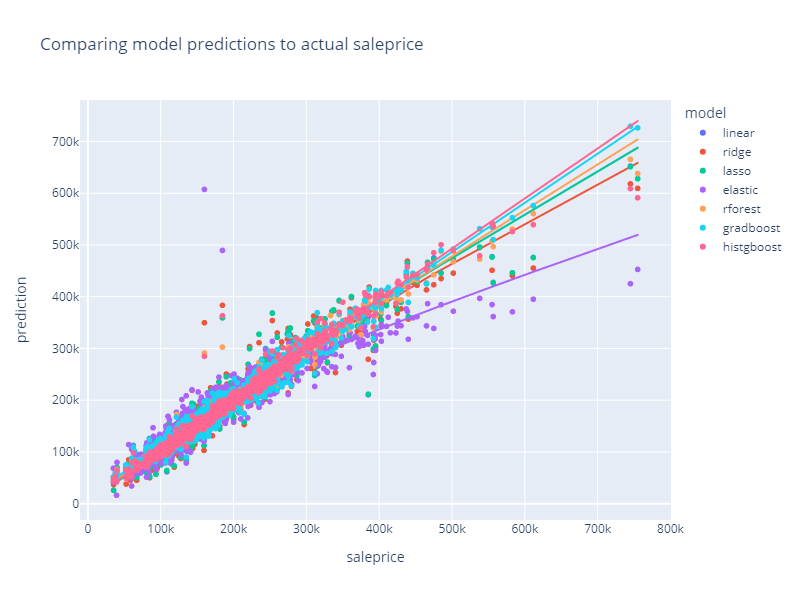

In [302]:
px.scatter(a,
    x = 'saleprice',
    y = 'prediction',
    color = 'model',
    trendline='lowess',
    height = 600,
    width = 800,
    title = "Comparing model predictions to actual saleprice").show('png')

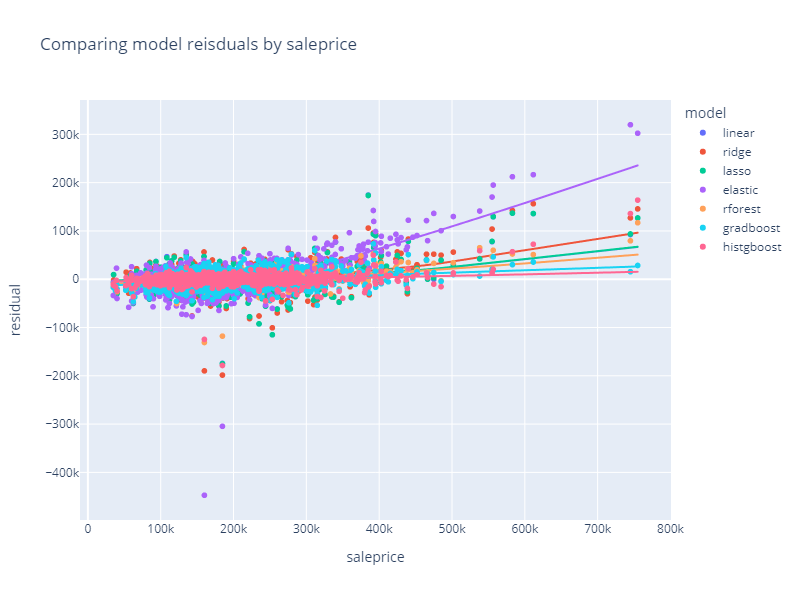

In [303]:
px.scatter(a,
    x = 'saleprice',
    y = 'residual',
    color = 'model',
    trendline='lowess',
    height = 600,
    width = 800,
    title = 'Comparing model reisduals by saleprice').show('png')

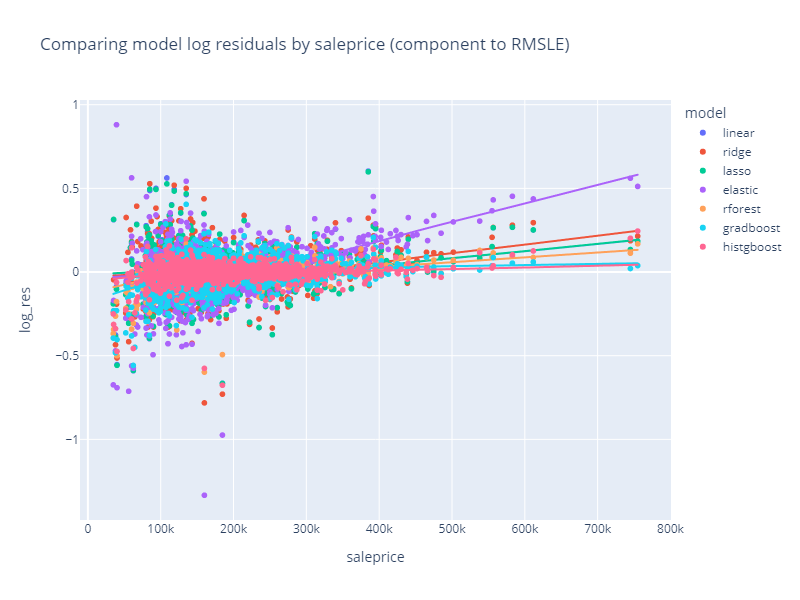

In [304]:
px.scatter(a,
    x = 'saleprice',
    y = 'log_res',
    color = 'model',
    trendline='lowess',
    height = 600,
    width = 800,
    title = 'Comparing model log residuals by saleprice (component to RMSLE)').show('png')

### Evaluating model on tiny test set

In [300]:
mean_squared_log_error(y_test, gb_reg.predict(X_test), squared = False)

0.15097350899968054